In [1]:
print("""
@Description: Learning Best Practices for Model Evaluation and Hyperparameter Tuning
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-06-12 14:12:21
""")


@Description: Learning Best Practices for Model Evaluation and Hyperparameter Tuning
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-06-12 14:12:21



# Learning Best Practices for Model Evaluation and Hyperparameter Tuning

## Streamlining workflows with pipelines

In [2]:
import sys
sys.path.append('./')
sys.path.append('../')
from data.get_data import DataLoader
dl = DataLoader()
X, y = dl.get_wdbc()

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    stratify=y, random_state=1)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


## Using k-fold cross-validation to assess model performance

In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, Class distr.: {np.bincount(y_train[train])}, Acc.: {score:.3f}')
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'CV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956
CV accuracy: 0.950 +/- 0.014


In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train, y=y_train, cv=10, n_jobs=-1)
print(f'CV accuracy scores: {scores}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [11]:
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.950 +/- 0.014


## Debugging algorithms with learning and validation curves

### Diagnosing bias and variance problems with learning curves

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10_000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train, y=y_train, train_sizes=np.linspace(.1, 1.0, 10),
                                                        cv=10, n_jobs=-1)

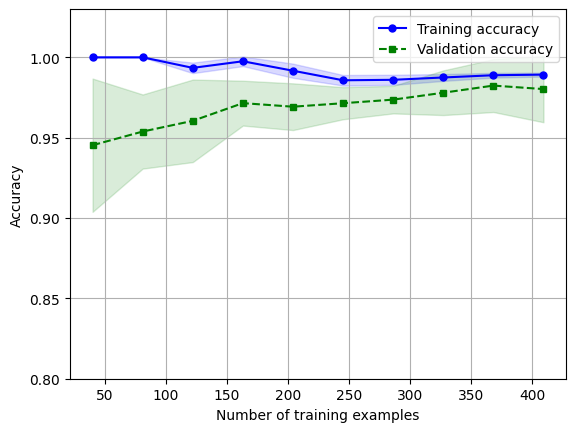

In [27]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, 
                 test_mean - test_std,
                 alpha=.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([.8, 1.03])
plt.show()

### Addressing over-and underfitting with validation curves

In [37]:
from sklearn.model_selection import validation_curve
param_range = [.001, .01, .1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range, cv=10)

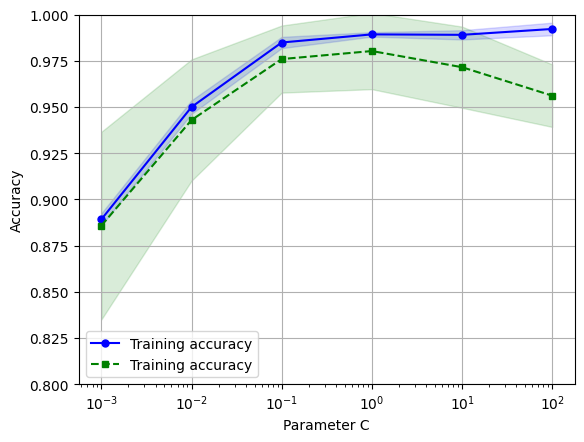

In [41]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
         color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=.15, color='blue')
plt.plot(param_range, test_mean, marker='s',
         color='green', linestyle='--', markersize=5, label='Training accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend()
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([.8, 1.0])
plt.show()